## Reinforcement Learning - Assisting Cab Drivers
### Cab-Driver Agent

In [1]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Colab Notebooks/RL-Assisting_Cab_Drivers')
%cd /content/gdrive/MyDrive/Colab Notebooks/RL-Assisting_Cab_Drivers

/content/gdrive/MyDrive/Colab Notebooks/RL-Assisting_Cab_Drivers


In [3]:
# Importing the libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# Constructing DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizer_v2.adam import Adam

# Graphing
import matplotlib.pyplot as plt

# Environment
from Env import CabDriver

In [4]:
env = CabDriver()

#### Defining Time Matrix

In [5]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [6]:
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

11.0
0.0
3.0542857142857143
7.93705306122449


Since the max time is 11 hours between any 2 points, the next state of the cab driver may increase at most by 1 day.

#### Tracking the state-action pairs for checking convergence


In [7]:
def encode_track_state(state):
    return ('-'.join(str(e) for e in state))

In [8]:
def encode_track_action(action):
    return ('-'.join(str(e) for e in action))

In [9]:
# Tracking the q-vals for all possible moves from position 3 at beginning of the episode
def initialise_tracking_states(episodes):
    sample_q_values = [('3-0-0', '1-2'), ('3-0-0', '2-1'), ('3-0-0', '1-3'), ('3-0-0', '3-1'), ('3-0-0', '1-4'), ('3-0-0', '4-1'), ('3-0-0', '1-5'), ('3-0-0', '5-1'), ('3-0-0', '2-3'), 
                       ('3-0-0', '3-2'), ('3-0-0', '2-4'), ('3-0-0', '4-2'), ('3-0-0', '2-5'), ('3-0-0', '5-2'), ('3-0-0', '3-4'), ('3-0-0', '4-3'), ('3-0-0', '3-5'), ('3-0-0', '5-3'), 
                       ('3-0-0', '4-5'), ('3-0-0', '5-4'), ('3-0-0', '0-0')]    
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []

         

In [10]:
# Save q-value for tracking a state-action pair
def save_tracking_states(curr_state, curr_action, curr_q_value):
    for state in States_track.keys():
        if state == curr_state:
            for action in States_track[state].keys():
                if action == curr_action:
                    States_track[state][action].append(curr_q_value)

In [11]:
# Pickling the q-dictionary
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class
- If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
- Initialise your input and output batch for training the model
- Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
- Get Q(s', a) values from the last trained model
- Update the input batch as your encoded state and output batch as your Q-values
- Then fit your DQN model using the updated input and output batch.

In [12]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Defining the size of state & action
        self.state_size = state_size
        self.action_size = action_size

        # Specifying the hyper-parameters for the DQN
        # We are using an epsilon-decay function epsilon = epsilon*epsilon_decay which has also been described at the end
        self.discount_factor = 0.95
        self.learning_rate =  0.001      
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        
        self.batch_size = 32  
        self.train_start = 50
        # Make a memory replay with deque
        self.memory = deque(maxlen=2000)

       # Construct main and target models
        self.model = self.build_model()
        print ("\n Target Neural Model: ")
        self.target_model = self.build_model()

        
            
    # Approximating q-function using a neural network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # input layer - input size would be state size
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output size is number of possible actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def update_target_model(self):
        # Updating the target Q-value network to current Q-value network after training for a episode. 
        # Parameters of the target Q-value network will be set as current Q-value network.
        self.target_model.set_weights(self.model.get_weights())


    def get_action(self, state, possible_actions):      
        if np.random.rand() <= self.epsilon:
            # Explore: Pick a random action from all allowed actions
            # The list of allowed actions is provided by the environment.
            choice = random.choice(possible_actions)
        else:
            # Pick an action which yields maximum q(s, a)
            q_values = self.model.predict(state)
            possible_action_q_values = list(q_values[0][index] for index in possible_actions)
            max_q_value = np.max(possible_action_q_values)
            choice = np.where(q_values[0] == max_q_value)
            choice = choice[0][0]
            
        return choice
        
    def get_q_values(self, state):
        return self.model.predict(state)[0]
    
    def append_sample(self, state, action, reward, next_state, done):
        # Add (s, a, r, s', done) tuple to replay buffer after each action
        self.memory.append((state, action, reward, next_state, done))
    
        # Decay in ε (epsilon) after generating each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay    
    
    def train_model(self):
        # Wait for memory queue to reach threshold before training the model
        if len(self.memory) < self.train_start:
            return
        
        # Sample batch from the memory
        batch_size = min(self.batch_size, len(self.memory))
        # Select samples randomly from replay memory to train the network
        mini_batch = random.sample(self.memory, self.batch_size)

        # Init the input and output batches for training the model
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size)) 
        actions, rewards, terminal_states = [], [], []

        for i in range(self.batch_size):

            update_input[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            terminal_states.append(mini_batch[i][4])

        # Predicting target from earlier model
        target = self.model.predict(update_input)

        # Obtaining the target for the Q-network
        target_qval = self.target_model.predict(update_target)  

        for i in range(self.batch_size):
            if terminal_states[i]:
                target[i][actions[i]] = rewards[i]
            else: # nonterminal state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

        # Fit the model and track the losses
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save(self, name):
        self.model.save_weights(name)
        
    def get_model_weights(self):
        return self.model.get_weights()

In [13]:
Episodes = 1000

### DQN block

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



 Target Neural Model: 
Episode: 100   score: 1108   memory length: 2000   epsilon: 0.009998671593271896
Episode: 200   score: 1241   memory length: 2000   epsilon: 0.009998671593271896
Episode: 300   score: 1229   memory length: 2000   epsilon: 0.009998671593271896
Episode: 400   score: 1371   memory length: 2000   epsilon: 0.009998671593271896
Episode: 500   score: 1471   memory length: 2000   epsilon: 0.009998671593271896
Episode: 600   score: 1435   memory length: 2000   epsilon: 0.009998671593271896
Episode: 700   score: 1579   memory length: 2000   epsilon: 0.009998671593271896
Episode: 800   score: 1440   memory length: 2000   epsilon: 0.009998671593271896
Episode: 900   score: 1727   memory length: 2000   epsilon: 0.009998671593271896
Episode: 1000   score: 1528   memory length: 2000   epsilon: 0.009998671593271896


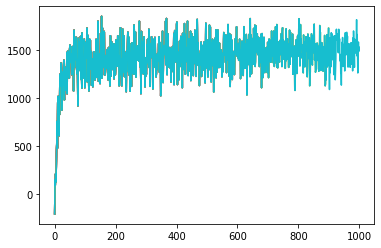

In [14]:
import pylab
scores, episodes = [], []
state = env.state_init
state_encoded = env.state_encod_arch1(state)
state_size = len(state_encoded)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
States_track = collections.defaultdict(dict)
initialise_tracking_states(Episodes) 

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state = False
    score = 0
    reward = 0
    total_days = 1
    previous_day = 0
    current_day = 0
    env.reset()
    

    #Call the DQN agent
    action_space, state_space, state = env.reset()
    track_state = state
    
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        state_encoded = env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])
        
        # Obtain the allowed list of actions from the environment
        possible_actions, action_list = env.requests(state)
        
        # Pick epsilon-greedy action from all allowed actions for the current state
        action = agent.get_action(state_encoded, possible_actions)
        
        # Evaluate your reward and next state
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        
        # Append the experience to the memory
        agent.append_sample(state_encoded, action, reward, next_state_encoded, terminal_state)
        
        # Train the model by calling the agent.train_model function
        agent.train_model()
        
        # Reward tracking
        score += reward
        previous_day = state[2]
        state = next_state
        current_day = state[2]
        if previous_day != current_day:
            total_days = total_days + 1
            
        if total_days > 30:
            terminal_state = True
            
        # At the end of 30 days, the target model is updated. Also the scores and episode are saved
        if terminal_state == True:
            agent.update_target_model()
            scores.append(score)
            episodes.append(episode)  
    
    # Track q-value convergence
    # After each episode the q-values will be predicted for all possible actions from the init state
    track_state_encode = encode_track_state(track_state)
    track_state_encoded = env.state_encod_arch1(track_state)
    track_state_encoded = np.reshape(track_state_encoded, [1, state_size])
    track_q_values = agent.get_q_values(track_state_encoded)
    
    for index in range(len(env.action_space)):
        track_action_encode = encode_track_action(env.action_space[index])
        save_tracking_states(track_state_encode, track_action_encode, track_q_values[index])
    
    # Save the graph as a PNG and the model as a pickle file
    # Saving after every n-th episode (n=100 here)
    if (episode + 1) % 100 == 0:
        print("Episode:", episode + 1, "  score:", score, "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon)
        pylab.plot(episodes, scores)
        pylab.savefig("cardriver_dqn_" + str(score) + ".png")
        save_obj(agent.get_model_weights(), "cardriver_dqn_" + str(score))
       

### Tracking Convergence

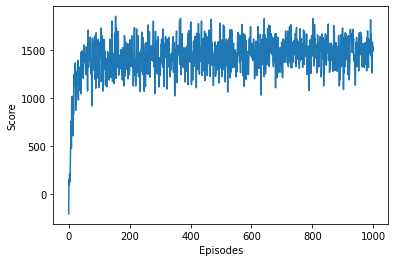

In [15]:

# Checking convergence with scores
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.plot(episodes, scores)


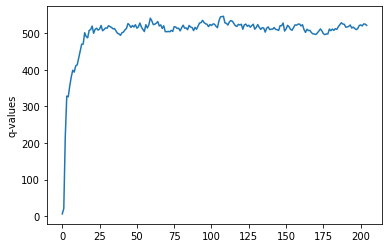

In [16]:
# State-action q-value graph
values = States_track['3-0-0']['3-4']
plt.ylabel('q-values')
plt.plot(values)

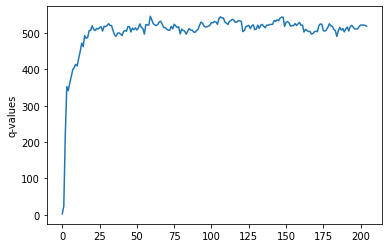

In [22]:
# State-action q-value graph
values = States_track['3-0-0']['3-2']
plt.ylabel('q-values')
plt.plot(values)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [23]:
time = np.arange(0,10000)
epsilon = []

for i in range(0,10000):
  
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

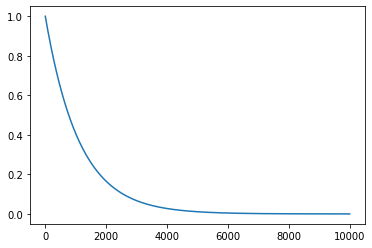

In [24]:
plt.plot(time, epsilon)
plt.show()

#### Epsilon-decay function used in this model
##### Notice that it has a very similar trend as the above function

In [25]:
# Epsilon decay function used in this model
time = np.arange(0,10000)
epsilon = []
epsilon_decay = .999
epsilon.append(1.0)
for i in range(1,10000):
    epsilon.append(epsilon[i-1] * epsilon_decay)

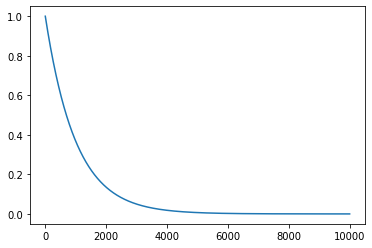

In [26]:
plt.plot(time, epsilon)
plt.show()